# File Structure

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/passwords/passwords.csv
/kaggle/input/password-strength-classifier-dataset/data.csv


# Package Import

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import multiprocessing as mp

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler,StandardScaler,LabelEncoder
from sklearn.compose import ColumnTransformer,make_column_selector

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler,StandardScaler,LabelEncoder

from sklearn.metrics import classification_report,roc_auc_score,ConfusionMatrixDisplay,f1_score,accuracy_score
from sklearn.exceptions import NotFittedError

import tensorflow as tf
import tensorflow_addons as tfa

sns.set_style('darkgrid')

%matplotlib inline

# Data Import

In [4]:
input_file='/kaggle/input/password-strength-classifier-dataset/data.csv'
df=pd.read_csv(input_file,error_bad_lines=False)
df.head()

Skipping line 2810: expected 2 fields, saw 5
Skipping line 4641: expected 2 fields, saw 5
Skipping line 7171: expected 2 fields, saw 5
Skipping line 11220: expected 2 fields, saw 5
Skipping line 13809: expected 2 fields, saw 5
Skipping line 14132: expected 2 fields, saw 5
Skipping line 14293: expected 2 fields, saw 5
Skipping line 14865: expected 2 fields, saw 5
Skipping line 17419: expected 2 fields, saw 5
Skipping line 22801: expected 2 fields, saw 5
Skipping line 25001: expected 2 fields, saw 5
Skipping line 26603: expected 2 fields, saw 5
Skipping line 26742: expected 2 fields, saw 5
Skipping line 29702: expected 2 fields, saw 5
Skipping line 32767: expected 2 fields, saw 5
Skipping line 32878: expected 2 fields, saw 5
Skipping line 35643: expected 2 fields, saw 5
Skipping line 36550: expected 2 fields, saw 5
Skipping line 38732: expected 2 fields, saw 5
Skipping line 40567: expected 2 fields, saw 5
Skipping line 40576: expected 2 fields, saw 5
Skipping line 41864: expected 2 field

,password,strength
0,kzde5577,1
1,kino3434,1
2,visi7k1yr,1
3,megzy123,1
4,lamborghin1,1


In [5]:
target='strength'
target

'strength'

In [6]:
col_drop_list=[]

# EDA (Describe , Info)

In [7]:
df.describe()

,strength
count,669640.000000
mean,0.990196
std,0.507948
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,2.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669640 entries, 0 to 669639
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   password  669639 non-null  object
 1   strength  669640 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 10.2+ MB


# Null Check

In [9]:
df.isna().sum()

password    1
strength    0
dtype: int64

In [10]:
df=df.dropna()

In [11]:
df.isna().sum()

password    0
strength    0
dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 669639 entries, 0 to 669639
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   password  669639 non-null  object
 1   strength  669639 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


# Duplicate check

In [13]:
df=df.drop_duplicates()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 669639 entries, 0 to 669639
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   password  669639 non-null  object
 1   strength  669639 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


# Feature Investigation

In [15]:
def col_unique_val_check(df):
    for i,col in enumerate(df.columns):
        print(f"{col:40} ----> {df[col].nunique():10} unique values   with dtype {str(df[col].dtype):10} at index {i}")  

In [16]:
df.shape

(669639, 2)

In [17]:
df.columns

Index(['password', 'strength'], dtype='object')

In [18]:
col_unique_val_check(df)

password                                 ---->     669639 unique values   with dtype object     at index 0
strength                                 ---->          3 unique values   with dtype int64      at index 1


# EDA

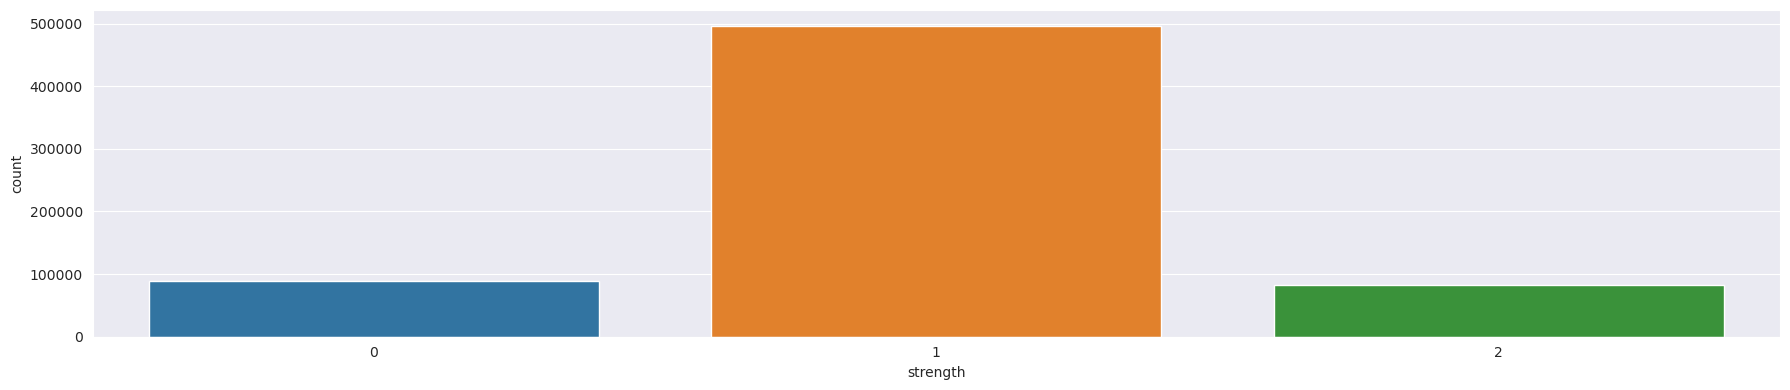

In [19]:
plt.figure(figsize=(18,4))
sns.countplot(x=target,data=df,palette='tab10')
plt.tight_layout()

# Separate X and Y

In [20]:
X=df.drop([target],axis=1)
y=df[[target]]

In [21]:
X.head()

,password
0,kzde5577
1,kino3434
2,visi7k1yr
3,megzy123
4,lamborghin1


In [22]:
y.head()

,strength
0,1
1,1
2,1
3,1
4,1


# Train Test Split

In [23]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,stratify=y,random_state=42)
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,stratify=y_train,random_state=42)

In [24]:
X_train.shape,y_train.shape

((542407, 1), (542407, 1))

In [25]:
X_test.shape,y_test.shape

((66964, 1), (66964, 1))

In [26]:
y_test.head(2)

,strength
202240,1
96126,1


In [27]:
X_train.columns,y_train.columns

(Index(['password'], dtype='object'), Index(['strength'], dtype='object'))

# Data Preprocess Pipeline

In [28]:
def password_features(X):
    
    X['password_processed']=X['password']
    X["length_step"]=X["password"].apply(lambda x:len(x) if(len(x)>5) else 0)
    X["small_char"]=X["password"].apply(lambda x: 1 if (re.search('[a-z]', x)) else 0)
    X["cap_char"]=X["password"].apply(lambda x: 1 if (re.search('[A-Z]', x)) else 0)
    X['special_char']=X['password'].apply(lambda x: 1 if (re.search('[@_!#$%^&*()<>?/\|}{~:]',x)) else 0)
    X['digi_char']=X['password'].apply(lambda x: 1 if (re.search('[0-9]', x)) else 0)
    
    X=X.drop(['password'],axis=1)
    
    return X

In [29]:
class DataProcessor:
    def __init__(self, num_workers=1):
        self.num_workers = num_workers

    def _process_chunk(self, X):

        X['password_processed']=X['password']
        X["length_step"]=X["password"].apply(lambda x:len(x) if(len(x)>5) else 0)
        X["small_char"]=X["password"].apply(lambda x: 1 if (re.search('[a-z]', x)) else 0)
        X["cap_char"]=X["password"].apply(lambda x: 1 if (re.search('[A-Z]', x)) else 0)
        X['special_char']=X['password'].apply(lambda x: 1 if (re.search('[@_!#$%^&*()<>?/\|}{~:]',x)) else 0)
        X['digi_char']=X['password'].apply(lambda x: 1 if (re.search('[0-9]', x)) else 0)
        
        X=X.drop(['password'],axis=1)
        
        return X

    def _parallelize_dataframe(self, df):
        num_rows = len(df)
        chunk_size = num_rows // self.num_workers
        chunks = [df.iloc[i:i + chunk_size] for i in range(0, num_rows, chunk_size)]

        with mp.Pool(processes=self.num_workers) as pool:
            processed_chunks = pool.map(self._process_chunk, chunks)

        return pd.concat(processed_chunks)

    def transform(self, df):
        return self._parallelize_dataframe(df)

In [30]:
y_oh=OneHotEncoder()

In [31]:
vectorizer=TfidfVectorizer(analyzer="char",dtype=np.float64)

ct=ColumnTransformer([
                        ('vectorizer',vectorizer,'password_processed') 
                    ],
                        remainder='passthrough',n_jobs=-1)

ct

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('vectorizer', TfidfVectorizer(analyzer='char'),
                                 'password_processed')])

# Data Preprocessing

## **X related Processing**

In [32]:
%%time
X_train=DataProcessor(num_workers=4).transform(X_train)
X_val=DataProcessor(num_workers=4).transform(X_val)
X_test=DataProcessor(num_workers=4).transform(X_test)

CPU times: user 521 ms, sys: 451 ms, total: 972 ms
Wall time: 2.45 s


In [33]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 542407 entries, 57022 to 661454
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   password_processed  542407 non-null  object
 1   length_step         542407 non-null  int64 
 2   small_char          542407 non-null  int64 
 3   cap_char            542407 non-null  int64 
 4   special_char        542407 non-null  int64 
 5   digi_char           542407 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 29.0+ MB


In [34]:
X_train.head(2)

,password_processed,length_step,small_char,cap_char,special_char,digi_char
57022,kacper12,8,1,0,0,1
435174,gamhzw1,7,1,0,0,1


In [35]:
# X_train=X_train.drop(['password'],axis=1)
# X_val=X_val.drop(['password'],axis=1)
# X_test=X_test.drop(['password'],axis=1)

In [36]:
X_train.head(2)

,password_processed,length_step,small_char,cap_char,special_char,digi_char
57022,kacper12,8,1,0,0,1
435174,gamhzw1,7,1,0,0,1


In [37]:
# ct.fit_transform(X_train.head(2))

In [38]:
%%time
X_train=ct.fit_transform(X_train)
X_val=ct.transform(X_val)
X_test=ct.transform(X_test)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


CPU times: user 734 ms, sys: 560 ms, total: 1.29 s
Wall time: 6.77 s


In [39]:
print("-"*50)
for i in ct.transformers_:
    print(i)
    if(i[0]!='remainder'):
        print(i[1].get_feature_names_out())   
    print("-"*50)

--------------------------------------------------
('vectorizer', TfidfVectorizer(analyzer='char'), 'password_processed')
['\x01' '\x02' '\x05' '\x06' '\x08' '\x0f' '\x10' '\x11' '\x12' '\x13'
 '\x16' '\x17' '\x18' '\x1b' '\x1c' '\x1d' '\x1e' ' ' '!' '"' '#' '$' '%'
 '&' '(' ')' '*' '+' '-' '.' '/' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9'
 ';' '<' '=' '>' '?' '@' '[' '\\' ']' '^' '_' '`' 'a' 'b' 'c' 'd' 'e' 'f'
 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x'
 'y' 'z' '{' '|' '}' '~' '\x7f' '\x81' '\x8d' '\xa0' '¡' '¢' '¤' '¦' '§'
 '¨' '«' '¯' '°' '±' '²' '³' '´' 'µ' '¶' '·' '¹' 'º' '»' '¼' '½' '¾' '¿'
 '×' 'ß' 'à' 'á' 'â' 'ã' 'ä' 'å' 'æ' 'ç' 'é' 'ê' 'í' 'ï' 'ð' 'ñ' 'ò' 'ó'
 'ô' 'õ' 'ö' '÷' 'ù' 'ú' 'û' 'ü' 'ý' 'þ' 'ÿ' 'œ' 'ƒ' '—' '‚' '‡' '…' '‹'
 '›' '™']
--------------------------------------------------
('remainder', 'passthrough', [1, 2, 3, 4, 5])
--------------------------------------------------


In [40]:
ct

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('vectorizer', TfidfVectorizer(analyzer='char'),
                                 'password_processed')])

## **Y related preprocessing**

In [41]:
y_train.value_counts()

strength
1           402408
0            72658
2            67341
dtype: int64

In [42]:
y_train.head(2)

,strength
57022,1
435174,0


In [43]:
import tensorflow as tf
y_oh.fit(y_train)
output_shape=len(y_oh.get_feature_names_out())

y_train_copy=y_train
y_val_copy=y_val
y_test_copy=y_test

y_train_tf_copy = tf.keras.utils.to_categorical(y_train_copy, num_classes=output_shape)
y_val_tf_copy = tf.keras.utils.to_categorical(y_val_copy, num_classes=output_shape)
y_test_tf_copy = tf.keras.utils.to_categorical(y_test_copy, num_classes=output_shape)

In [44]:
X_train.shape,y_train.shape

((542407, 153), (542407, 1))

In [45]:
X_test.shape,y_test.shape

((66964, 153), (66964, 1))

In [46]:
tup1=None;tup2=None
try:
    tup1=(X_train[0].toarray(),y_train_tf_copy[0]) 
    print("Sparse Matrix to Dense Array")
except:
    tup2=(X_train[0],y_train_tf_copy[0]) 
    print("Normal Matrix to Dense Array")

tup1 if(tup1) else tup2

Sparse Matrix to Dense Array


(array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.27482085, 0.31879114, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.26535734, 0.        ,
         0.41546912, 0.        , 0.31091746, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.410094  , 0.        ,
         0.        , 0.        , 0.        , 0.43717586, 0.        ,
         0.35191918, 0.        , 0

# Tensorflow Batch Settings

In [47]:
batch_size=2048

In [48]:
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))

X_train=convert_sparse_matrix_to_sparse_tensor(X_train)
X_val=convert_sparse_matrix_to_sparse_tensor(X_val)
X_test=convert_sparse_matrix_to_sparse_tensor(X_test)

In [49]:
data_tf_tr=tf.data.Dataset.from_tensor_slices((X_train, y_train_tf_copy))
data_train_batches = data_tf_tr.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

data_tf_val=tf.data.Dataset.from_tensor_slices((X_val, y_val_tf_copy))
data_val_batches = data_tf_val.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

data_tf_te=tf.data.Dataset.from_tensor_slices((X_test, y_test_tf_copy))
data_test_x_y_batches = data_tf_te.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [50]:
#Only for X_test
data_tf_tre=tf.data.Dataset.from_tensor_slices(X_test)
data_test_x_batches = data_tf_tre.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

# Model fitting

## Neural Network Settings

In [51]:
n,m=5,4

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Input,PReLU,LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

l_relu=LeakyReLU()
para_relu = PReLU()
e=EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)

In [53]:
y_train_tf_copy.shape

(542407, 3)

In [54]:
input_shape_val=X_train.shape[1]
X_train.shape,[input_shape_val]

(TensorShape([542407, 153]), [153])

In [55]:
model=Sequential()

#Input Layer
model.add(Input(shape=(input_shape_val,)))

#Hidden Layer
model.add(Dense((m*n)*input_shape_val , activation=para_relu ))
model.add(Dense((m*n)*input_shape_val , activation=para_relu ))
model.add(Dense((m*n)*input_shape_val , activation='relu'))
model.add(Dense((m*n)*input_shape_val , activation=para_relu ))
model.add(Dense((m*n)*input_shape_val , activation=para_relu ))

#Output Layer
model.add(Dense(output_shape,activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics = [ 'accuracy',
                         tf.keras.metrics.AUC(name='AUC_ROC',curve='ROC',num_thresholds=10000) ,
                         tfa.metrics.F1Score(name='F1_Score',num_classes=output_shape,average='macro',threshold=0.5)
                        ]
             )

In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3060)              474300    
                                                                 
 dense_1 (Dense)             (None, 3060)              9369720   
                                                                 
 dense_2 (Dense)             (None, 3060)              9366660   
                                                                 
 dense_3 (Dense)             (None, 3060)              9369720   
                                                                 
 dense_4 (Dense)             (None, 3060)              9369720   
                                                                 
 dense_5 (Dense)             (None, 3)                 9183      
                                                                 
Total params: 37,950,123
Trainable params: 37,950,123
No

In [57]:
#from tensorflow.keras.utils import plot_model
#plot_model(model, to_file='model.png',show_shapes=True,show_dtype=True,show_layer_activations=True)

In [58]:
%%time
history=model.fit(data_train_batches,epochs=10,callbacks=[e,reduce_lr],
                  validation_data=data_val_batches,verbose=1)

Epoch 1/10
265/265 [==============================] - 33s 100ms/step - loss: 0.1258 - accuracy: 0.9600 - AUC_ROC: 0.9964 - F1_Score: 0.9404 - val_loss: 0.0015 - val_accuracy: 0.9999 - val_AUC_ROC: 1.0000 - val_F1_Score: 0.9998 - lr: 0.0010
Epoch 2/10
265/265 [==============================] - 23s 88ms/step - loss: 5.3489e-04 - accuracy: 0.9999 - AUC_ROC: 1.0000 - F1_Score: 0.9998 - val_loss: 5.0598e-04 - val_accuracy: 0.9999 - val_AUC_ROC: 1.0000 - val_F1_Score: 0.9998 - lr: 0.0010
Epoch 3/10
265/265 [==============================] - 23s 87ms/step - loss: 0.4140 - accuracy: 0.9216 - AUC_ROC: 0.9815 - F1_Score: 0.8777 - val_loss: 0.0032 - val_accuracy: 0.9991 - val_AUC_ROC: 1.0000 - val_F1_Score: 0.9986 - lr: 0.0010
Epoch 4/10
265/265 [==============================] - 23s 88ms/step - loss: 0.0011 - accuracy: 0.9997 - AUC_ROC: 1.0000 - F1_Score: 0.9995 - val_loss: 3.4922e-04 - val_accuracy: 0.9999 - val_AUC_ROC: 1.0000 - val_F1_Score: 0.9999 - lr: 0.0010
Epoch 5/10
265/265 [===========

# Testing

In [59]:
model.evaluate(data_test_x_y_batches)

33/33 [==============================] - 1s 33ms/step - loss: 3.0947e-04 - accuracy: 0.9999 - AUC_ROC: 1.0000 - F1_Score: 0.9999


[0.0003094722342211753, 0.9999253153800964, 1.0, 0.9998888373374939]

In [60]:
score_dict={};j=0

In [61]:
def tester_func(model_list,X_test,y_test):
    for i,clf in enumerate(model_list):
       
        pred_proba=None;pred=None
        clf_name = clf.__class__.__name__

        try:
            pred_proba=clf.predict(X_test)
            pred=np.argmax(clf.predict(X_test), axis=-1)
        except NotFittedError as e:
            raise(e)

        print("-"*80)
        print(f"Predicting {clf_name} done")
        
        if(str(df[target].dtype)!='object'):
            print("Non object mode testing .........")
            score_dict[clf_name]={
                'roc_auc_score':roc_auc_score(y_test.values,pred_proba,multi_class='ovr'),
                'f1_score':f1_score(y_test.values,pred,average='macro'),
                'accuracy_score':accuracy_score(y_test.values,pred),
                'model_index':int(i)
            }
            
        else:
            print("Object mode testing .........")
            score_dict[clf_name]={
                'roc_auc_score':roc_auc_score(y_test,pred_proba,multi_class='ovr'),
                'f1_score':f1_score(y_test,pred,average='macro'),
                'accuracy_score':accuracy_score(y_test,pred),
                'model_index':int(i)
            }
    
        j=i
    
    print("-"*80)
    return j

In [62]:
indexer=tester_func([model],X_test,y_test_copy)

2093/2093 [==============================] - 5s 2ms/step
--------------------------------------------------------------------------------
Predicting Sequential done
Non object mode testing .........
--------------------------------------------------------------------------------


In [63]:
score_pd=pd.DataFrame(score_dict).transpose().sort_values('f1_score',ascending=False)
score_pd

,accuracy_score,f1_score,model_index,roc_auc_score
Sequential,0.999925,0.999889,0.0,1.0


# Confusion Matrix for Top Model

In [64]:
prediction=np.argmax(model.predict(X_test), axis=-1)
prediction

2093/2093 [==============================] - 5s 2ms/step


array([1, 1, 0, ..., 1, 1, 1])

In [65]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, prediction)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.99%


In [66]:
y_test

,strength
202240,1
96126,1
572333,0
570515,1
73341,1
...,...
656076,1
536073,1
535431,1
447838,1


In [67]:
print(classification_report( y_test.values , prediction ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8970
           1       1.00      1.00      1.00     49680
           2       1.00      1.00      1.00      8314

    accuracy                           1.00     66964
   macro avg       1.00      1.00      1.00     66964
weighted avg       1.00      1.00      1.00     66964



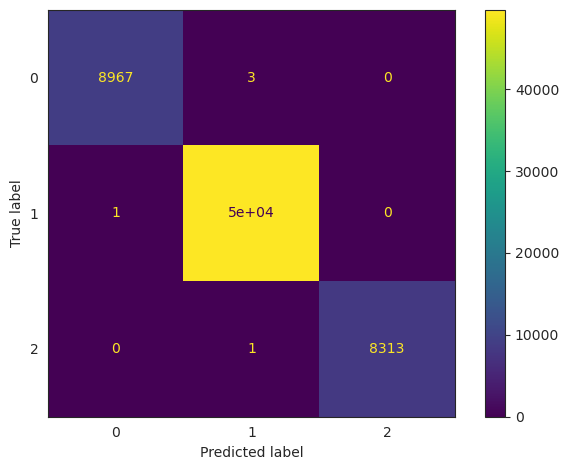

In [68]:
sns.set_style('white')
ConfusionMatrixDisplay.from_predictions( y_test.values , prediction )
plt.tight_layout()

 # Time to crack the password 

In [69]:
import time

def crack_time(password):
  length = len(password)
  chars = 94 # number of printable ASCII characters
  guesses = chars ** length # total number of guesses needed
  
  guesses_per_second = 100_000_000 # assume 100 million guesses per second
  
  seconds = guesses / guesses_per_second
  minutes, seconds = divmod(seconds, 60)
  hours, minutes = divmod(minutes, 60)
  days, hours = divmod(hours, 24)

  print(f"It would take approximately {days} days, {hours} hours, {minutes} minutes and {seconds} seconds to crack the password '{password}' using brute force at a rate of {guesses_per_second} guesses per second.")

# Manual Testing

In [78]:
def enter(test_pd):
    test=pd.DataFrame({'password':[test_pd]})
    test['password_processed']=test["password"]
    test["length_step"]=test["password"].apply(lambda x:len(x) if(len(x)>5) else 0)
    test["small_char"]=test["password"].apply(lambda x: 1 if (re.search('[a-z]', x)) else 0)
    test["cap_char"]=test["password"].apply(lambda x: 1 if (re.search('[A-Z]', x)) else 0)
    test['special_char']=test['password'].apply(lambda x: 1 if (re.search('[@_!#$%^&*()<>?/\|}{~:]',x)) else 0)
    test['digi_char']=test['password'].apply(lambda x: 1 if (re.search('[0-9]', x)) else 0)
    test=test.drop(['password'],axis=1)
    test_pd_copy=ct.transform(test)
    test_pd_copy.toarray()
    pred=np.argmax(model.predict(test_pd_copy), axis=-1)
    if pred[0]==0:
     print("Password is weak")
    elif pred[0]==1:
     print("Password is normal")
    else:
     print("pasword is strong")
    length = len(test_pd)
    chars = 94 # number of printable ASCII characters
    guesses = chars ** length # total number of guesses needed

    guesses_per_second = 100_000_000 # assume 100 million guesses per second

    seconds = guesses / guesses_per_second
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    days, hours = divmod(hours, 24)
    print(f"It would take approximately {days} days, {hours} hours, {minutes} minutes and {seconds} seconds to crack the password '{test_pd}' using brute force at a rate of {guesses_per_second} guesses per second.")

  


In [ ]:
test=input()
enter(test)

In [72]:
import pickle

In [73]:
with open('password.pkl','wb') as file:
    pickle.dump(model, file)

In [74]:
with open('password_1.pkl','wb') as file:
    pickle.dump(enter, file)